# Analysis of eCFR Agency Data

### Step 1: Download the top-level agency data using an API endpoint

In [6]:
import requests
import json
import pandas as pd

url = "https://www.ecfr.gov/api/admin/v1/agencies.json"
response = requests.get(url)
data = response.json()

print(json.dumps(data, indent=2))

{
  "agencies": [
    {
      "name": "Administrative Conference of the United States",
      "short_name": "ACUS",
      "display_name": "Administrative Conference of the United States",
      "sortable_name": "Administrative Conference of the United States",
      "slug": "administrative-conference-of-the-united-states",
      "children": [],
      "cfr_references": [
        {
          "title": 1,
          "chapter": "III"
        }
      ]
    },
    {
      "name": "Advisory Council on Historic Preservation",
      "short_name": "ACHP",
      "display_name": "Advisory Council on Historic Preservation",
      "sortable_name": "Advisory Council on Historic Preservation",
      "slug": "advisory-council-on-historic-preservation",
      "children": [],
      "cfr_references": [
        {
... [truncated for Git preview]

> After analyzing the output from the agencies JSON above, I determined that the cfr_references field will be used to index into the XML API with the following hierarchical data to be used as keys:
> - `title`
> - `subtitle`
> - `chapter`
> - `subchapter`
> - `part`
 
> Specifically, these keys are essential for querying endpoints like:

```
https://www.ecfr.gov/api/versioner/v1/full/{date}/title-{title}.xml?chapter={chapter}
```

> This API endpoint returns the regulation text content for the specific title, subtitle, chapter, subchapter, and part. Importantly, the title source route can be used to retrieve the source XML for either a complete title or a subset. The subset of XML is determined by the lowest leaf node given. For example, if you request Title 1, Chapter I, you’ll receive the XML only for Chapter I and its children. This granularity allows us to extract and further analyze the textual content of the regulations in a targeted manner.

### Step 2: Create a data frame and extract all the relevant keys

In [28]:
# Create a data frame from the agencies list
agencies_df = pd.DataFrame(data['agencies'])

# Print the data frame
# agencies_df.head()

# Expand the nested 'cfr_references' column (which is a list)
# Each agency might have one or more CFR references. This puts each reference on its own row.
agencies_df = agencies_df.explode('cfr_references')

# Extract all the relevant keys from the cfr_references dictionary
# If an agency doesn't have a valid dict in 'cfr_references', declare as None.
agencies_df['title']      = agencies_df['cfr_references'].apply(lambda x: x.get('title') if isinstance(x, dict) else None)
agencies_df['subtitle']   = agencies_df['cfr_references'].apply(lambda x: x.get('subtitle') if isinstance(x, dict) else None)
agencies_df['chapter']    = agencies_df['cfr_references'].apply(lambda x: x.get('chapter') if isinstance(x, dict) else None)
agencies_df['subchapter'] = agencies_df['cfr_references'].apply(lambda x: x.get('subchapter') if isinstance(x, dict) else None)
agencies_df['part']       = agencies_df['cfr_references'].apply(lambda x: x.get('part') if isinstance(x, dict) else None)

# Drop columns not needed
agencies_df.drop(columns=['cfr_references'], inplace=True)
agencies_df.drop(columns=['display_name'], inplace=True)
agencies_df.drop(columns=['sortable_name'], inplace=True)

# Print only essential info in the data frame
agencies_df.head()


,name,short_name,slug,children,title,subtitle,chapter,subchapter,part
0,Administrative Conference of the United States,ACUS,administrative-conference-of-the-united-states,[],1,None,III,None,None
1,Advisory Council on Historic Preservation,ACHP,advisory-council-on-historic-preservation,[],36,None,VIII,None,None
2,Special Inspector General for Afghanistan Reco...,SIGAR,special-inspector-general-for-afghanistan-reco...,[],5,None,LXXXIII,None,None
3,African Development Foundation,USADF,african-development-foundation,[],22,None,XV,None,None
3,African Development Foundation,USADF,african-development-foundation,[],48,None,57,None,None


In [30]:
# Save data frame to a csv file
agencies_df.to_csv("federal_agency_list.csv", index=False)
print("Data frame saved to federal_agency_list.csv")

Data frame saved to federal_agency_list.csv


### Step 3: Fetch the agency text using an API endpoint

In [32]:
from bs4 import BeautifulSoup

"""
Given a title (e.g., 1) and a chapter (as an integer or Roman numeral, i.e., 'III' or 3),
and optionally subtitle, subchapter, and part this function:
   
- Constructs the API URL for the full title XML.
- Appends query parameters for chapter and any additional keys provided.
- Fetches the XML data and extracts text content from all paragraphs (<P> tags)
  found within section elements.
    
The API returns a subset of the title's XML corresponding to the lowest leaf node specified.
For example, if you request Title 1, Chapter I, you'll receive the XML for Chapter I and its children.
If a deeper node such as Part or Subchapter is specified, the response is limited accordingly.
"""
def fetch_agency_text(title, chapter, subtitle=None, subchapter=None, part=None, date='2025-03-27'):
    # Construct the API URL using the date, title, and chapter
    base_url = f"https://www.ecfr.gov/api/versioner/v1/full/{date}/title-{title}.xml"

    # Build the query parameters based on the provided keys
    params = {}
    if chapter is not None:
        params['chapter'] = chapter
    if part is not None:
        params['part'] = part
    if subtitle is not None:
        params['subtitle'] = subtitle
    if subchapter is not None:
        params['subchapter'] = subchapter

    # Print the fully constructed URL for debugging/checkpoint
    full_url = requests.Request('GET', base_url, params=params).prepare().url
    print(f"Fetching URL: {full_url}")
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raise an error for non-200 status codes
    except requests.RequestException as e:
        print(f"Error fetching URL: {base_url} with params {params}\n{e}")
        return None

    # Parse the XML using BeautifulSoup
    soup = BeautifulSoup(response.content, "xml")
    
    # Find all elements with attribute TYPE="SECTION"
    sections = soup.find_all(attrs={"TYPE": "SECTION"})
    
    # Extract text from all <P> tags within each section,
    # using a space as a separator to preserve spacing
    paragraphs = []
    for section in sections:
        for p in section.find_all("P"):
            paragraphs.append(p.get_text(separator=" ", strip=True))
    
    # Concatenate all paragraphs with newline characters
    text_content = "\n".join(paragraphs)
    return text_content

### Step 4: Create a list of unique agencies and iterate over them to process each CFR reference

In [34]:

# Build a list of unique federal agencies (based on the 'name' column)
unique_agencies = agencies_df['name'].unique()
total_agencies = len(unique_agencies)
print(f"Total unique agencies to process: {total_agencies}")

results = []  # To store the result for each agency

# Loop over each unique agency
for i, agency in enumerate(unique_agencies):
    print(f"Processing agency {i+1}/{total_agencies}: {agency}")
    
    # Get all rows corresponding to this agency
    group = agencies_df[agencies_df['name'] == agency]
    texts = []
    
    # Process each row (each CFR reference) for this agency
    for _, row in group.iterrows():
        title      = row['title']
        chapter    = row['chapter']
        part       = row.get('part')
        subtitle   = row.get('subtitle')
        subchapter = row.get('subchapter')
        
        # Skip if title or chapter is missing
        if pd.isnull(title) or pd.isnull(chapter):
            continue
        
        # Fetch text content using the fetch_agency_text function
        text = fetch_agency_text(title, chapter, subtitle=subtitle, subchapter=subchapter, part=part)
        texts.append(text if text is not None else "")
    
    # Combine the text results from all rows for this agency
    combined_text = "\n\n".join(texts)
    
    # Save the agency info (using the first row of the group) with the combined text
    agency_info = group.iloc[0].to_dict()
    agency_info['text_content'] = combined_text
    results.append(agency_info)

# Create a new DataFrame from the results
results_df = pd.DataFrame(results)
print(results_df.head())


Total unique agencies to process: 153
Processing agency 1/153: Administrative Conference of the United States
Fetching URL: https://www.ecfr.gov/api/versioner/v1/full/2025-03-27/title-1.xml?chapter=III
Processing agency 2/153: Advisory Council on Historic Preservation
Fetching URL: https://www.ecfr.gov/api/versioner/v1/full/2025-03-27/title-36.xml?chapter=VIII
Processing agency 3/153: Special Inspector General for Afghanistan Reconstruction
Fetching URL: https://www.ecfr.gov/api/versioner/v1/full/2025-03-27/title-5.xml?chapter=LXXXIII
Processing agency 4/153: African Development Foundation
Fetching URL: https://www.ecfr.gov/api/versioner/v1/full/2025-03-27/title-22.xml?chapter=XV
Fetching URL: https://www.ecfr.gov/api/versioner/v1/full/2025-03-27/title-48.xml?chapter=57
Processing agency 5/153: United States Agency for Global Media
Fetching URL: https://www.ecfr.gov/api/versioner/v1/full/2025-03-27/title-22.xml?chapter=V
Fetching URL: https://www.ecfr.gov/api/versioner/v1/full/2025-03-

In [38]:
# Save the updated data frame (warning: ~3 GB file size)
# results_df.to_csv("federal_agency_list_with_text.csv", index=False)
# print("Data frame saved to federal_agency_list_with_text.csv")

Data frame saved to federal_agency_list_with_text.csv


In [39]:
import os

# Create a directory to store individual agency CSV files
output_dir = "federal_agency_texts"
os.makedirs(output_dir, exist_ok=True)

# Iterate over each row in the results DataFrame
for index, row in results_df.iterrows():
    agency_name = row['name']
    
    # Create a safe filename by keeping only alphanumeric characters, spaces, and underscores
    safe_agency_name = "".join(c for c in agency_name if c.isalnum() or c in (" ", "_")).rstrip().replace(" ", "_")
    file_path = os.path.join(output_dir, f"{safe_agency_name}.csv")
    
    # Create a DataFrame for the single row and save it to CSV
    pd.DataFrame([row]).to_csv(file_path, index=False)
    print(f"Saved {agency_name} data to {file_path}")


Saved Administrative Conference of the United States data to federal_agency_texts/Administrative_Conference_of_the_United_States.csv
Saved Advisory Council on Historic Preservation data to federal_agency_texts/Advisory_Council_on_Historic_Preservation.csv
Saved Special Inspector General for Afghanistan Reconstruction data to federal_agency_texts/Special_Inspector_General_for_Afghanistan_Reconstruction.csv
Saved African Development Foundation data to federal_agency_texts/African_Development_Foundation.csv
Saved United States Agency for Global Media data to federal_agency_texts/United_States_Agency_for_Global_Media.csv
Saved Department of Agriculture data to federal_agency_texts/Department_of_Agriculture.csv
Saved Air Transportation System Stabilization data to federal_agency_texts/Air_Transportation_System_Stabilization.csv
Saved American Battle Monuments Commission data to federal_agency_texts/American_Battle_Monuments_Commission.csv
Saved Appalachian Regional Commission data to federa

In [41]:
# Compute word count for each row's text_content
results_df['word_count'] = results_df['text_content'].apply(lambda text: len(str(text).split()))


In [42]:
# Print the top 10 agencies by regulation word count
results_df[['name', 'word_count']].sort_values(by='word_count', ascending=False).head(10)


,name,word_count
37,Environmental Protection Agency,40322278
91,Department of Justice,19397704
5,Department of Agriculture,14293756
24,Department of Defense,13561676
129,Office of Personnel Management,13211146
72,Gulf Coast Ecosystem Restoration Council,12134264
55,Federal Permitting Improvement Steering Council,11901500
14,Chemical Safety and Hazard Investigation Board,11901500
146,Department of Treasury,10999246
35,Department of Energy,10243165


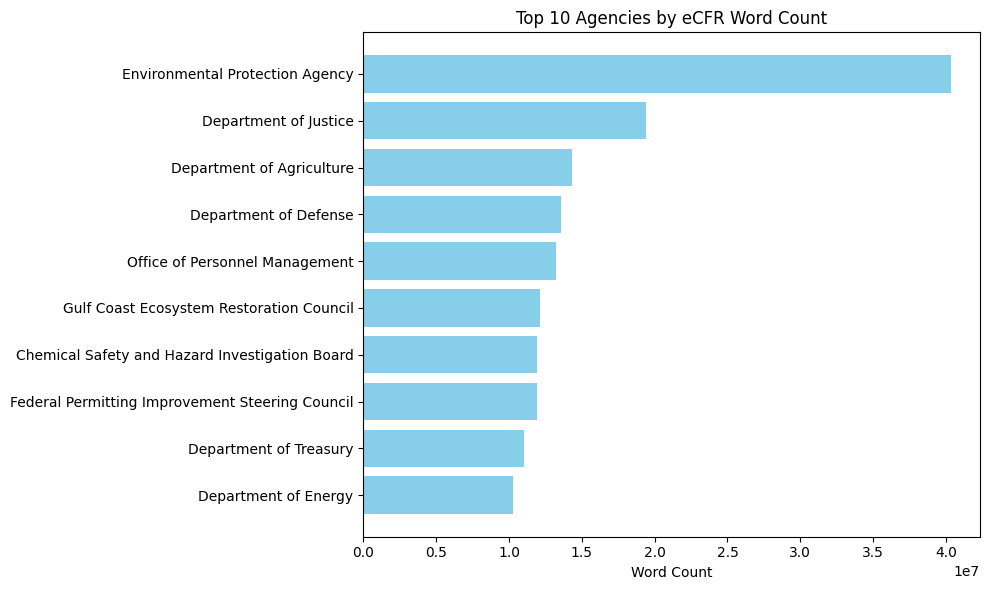

In [44]:
import matplotlib.pyplot as plt

# --- Plot: Top 10 Agencies by Word Count ---
top10 = results_df.nlargest(10, 'word_count')

plt.figure(figsize=(10, 6))
plt.barh(top10['name'], top10['word_count'], color='skyblue')
plt.xlabel('Word Count')
plt.title('Top 10 Agencies by eCFR Word Count')
plt.gca().invert_yaxis()  # Most words at top
plt.tight_layout()
plt.show()

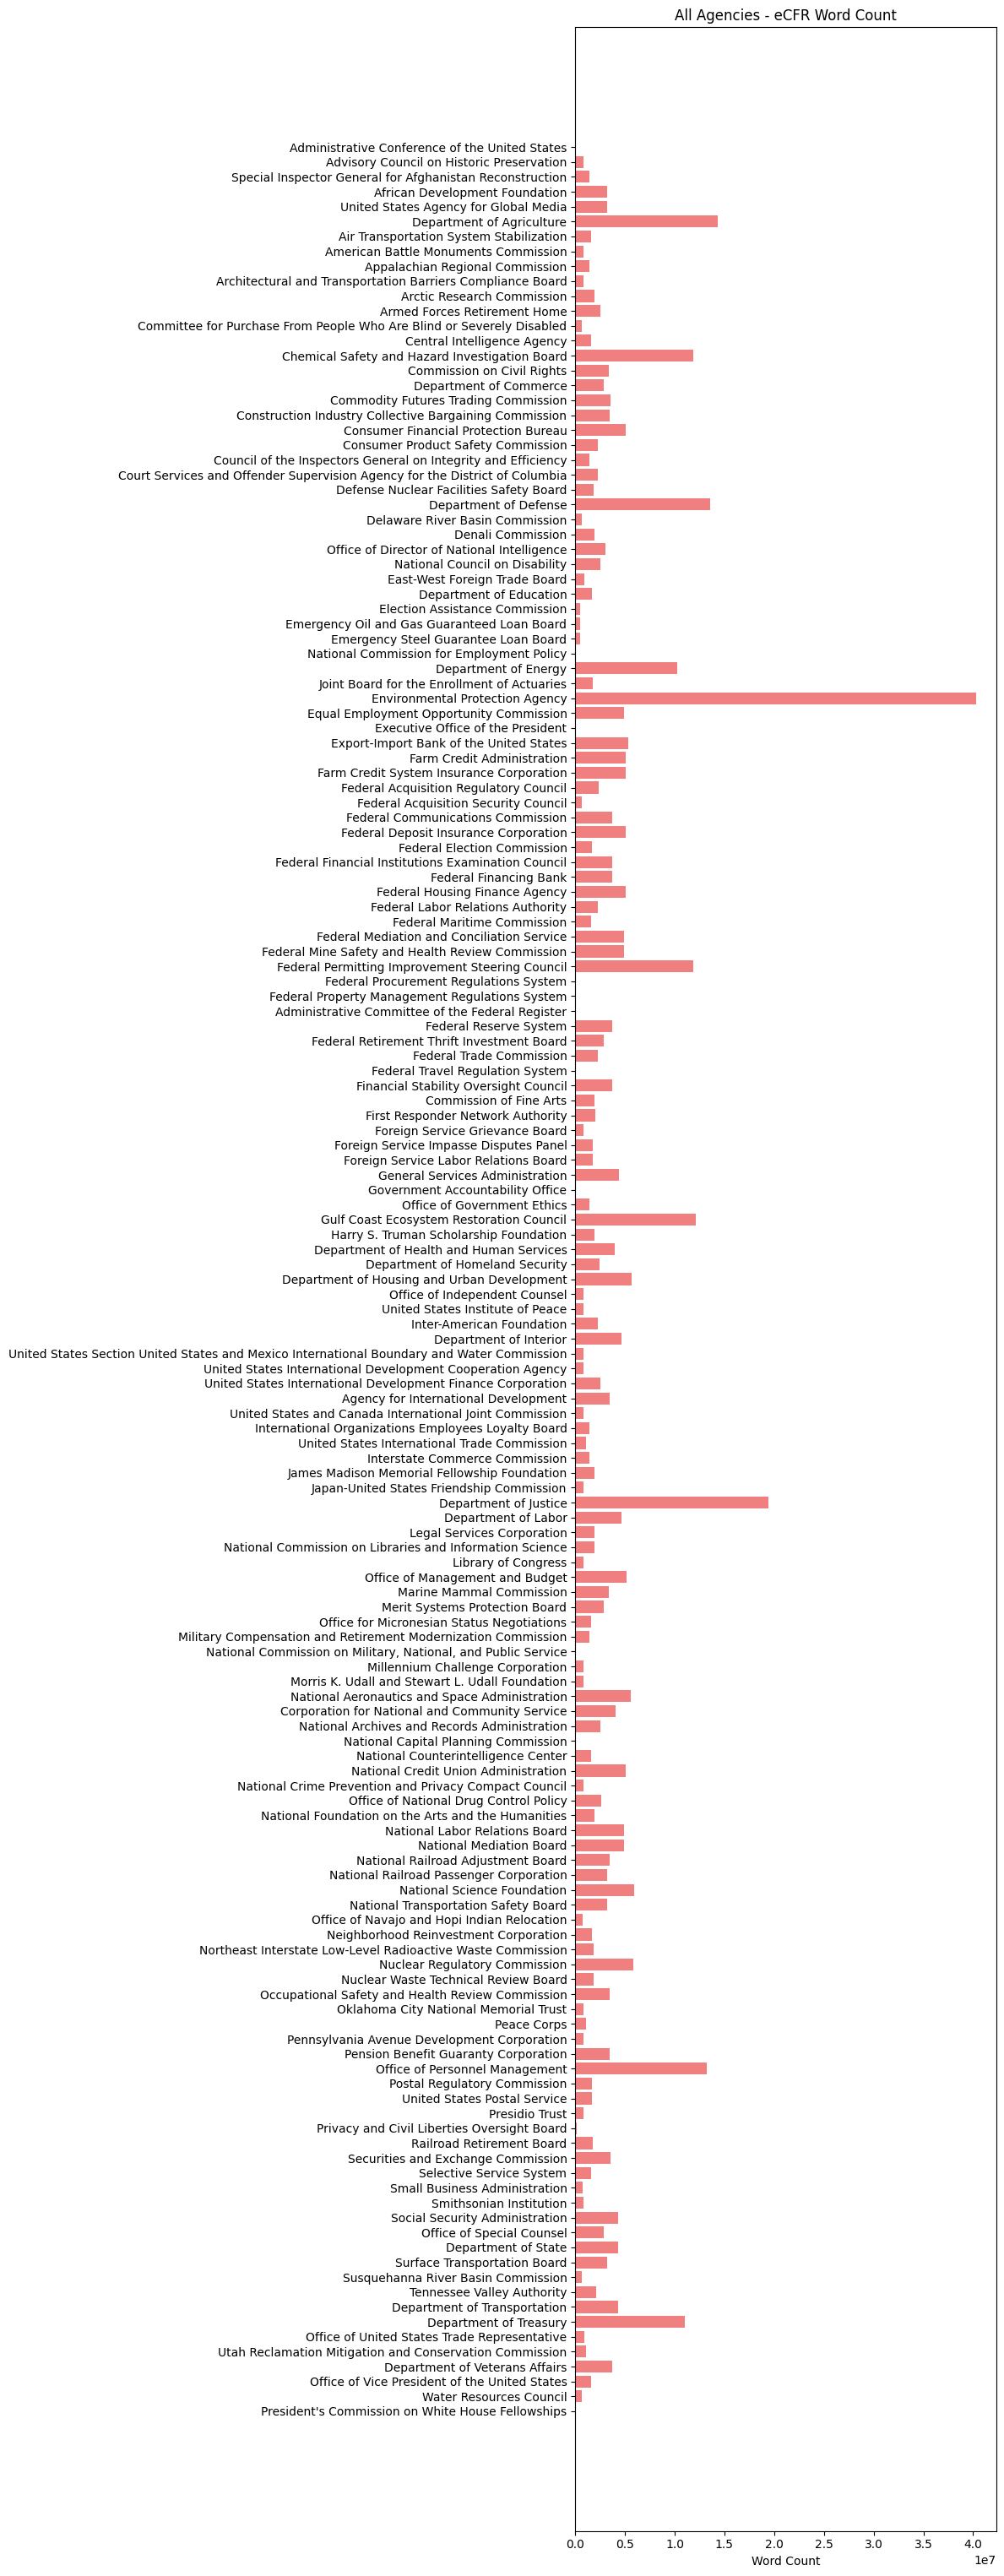

In [48]:
# --- Plot: All Agencies by Word Count ---
plt.figure(figsize=(12, max(6, len(results_df) * 0.2)))  # Dynamically adjust height
plt.barh(results_df['name'], results_df['word_count'], color='lightcoral')
plt.xlabel('Word Count')
plt.title('All Agencies - eCFR Word Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()